###  先对分类变量做哑编码，再利用20171017_05xgboost_under_sampling的方法调参得到一组最优参数

In [11]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

In [12]:
train_df=pd.read_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/train.csv',na_values=-1)
test_df=pd.read_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/test.csv',na_values=-1)
sample_df=pd.read_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/sample_submission.csv')

In [13]:
train_df.fillna(np.nan,inplace=True)
test_df.fillna(np.nan,inplace=True)

In [14]:
train_df.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0


In [15]:
#所有二元变量
bin_features=[feat for feat in train_df.columns if 'bin' in feat]
#所有的分类变量
cat_features=[feat for feat in train_df.columns if 'cat' in feat]

# 1 Data Analysis

## 1.1 dummy

In [16]:
feat_dummies=pd.get_dummies(train_df[cat_features].append(test_df[cat_features]),columns=cat_features,dummy_na=True)

In [17]:
train_df=train_df.T.append((feat_dummies.iloc[:train_df.shape[0]]).T).T
test_df=test_df.T.append((feat_dummies.iloc[train_df.shape[0]:]).T).T

In [18]:
use_features=[x for x in train_df.columns if x not in ['id','target']+cat_features]

use_features=[x for x in train_df.columns if x not in ['id','target']]

In [19]:
X=train_df[use_features]
y=train_df['target']

X_predict=test_df[use_features]

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y,random_state=9)

### 下采样，直接从负类中无放回随机抽样与正类等量的样本

In [24]:
X_train_P=X_train.loc[y_train==1]
X_train_N=X_train.loc[y_train==0]

y_train_P=y_train[y_train==1]
y_train_N=y_train[y_train==0]

In [25]:
X_train_N_sample,y_train_N_sample=shuffle(X_train_N,y_train_N,random_state=9,n_samples=X_train_P.shape[0])

In [26]:
X_train_sample,y_train_sample=shuffle(X_train_N_sample.append(X_train_P),y_train_N_sample.append(y_train_P),random_state=9)

In [27]:
X_train_sample.shape,y_train_sample.shape

((32542, 232), (32542,))

# 2 Modelling

## 2.1 Base line

In [28]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

def gini_normalized(preds,dtrain):
    y=dtrain.get_label()
    preds=softmax(preds)
    return 'NormGini',-gini(y, preds) / gini(y, y)

def gini_normalized_ordinary(y,preds):
    return gini(y, preds) / gini(y, y)

def gini_normalized_ordinary_model(model,X,y):
    preds=model.predict_proba(X)[:,1]
    return gini(y, preds) / gini(y, y)


def modelfit(alg,X,y,X_test,y_test,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    if useTrainCV==True:
        xgb_param=alg.get_xgb_params()
        xgtrain=xgb.DMatrix(X,label=y,missing=None)
        cvresult=xgb.cv(xgb_param,xgtrain,num_boost_round=50000,nfold=cv_folds,feval=gini_normalized,
                        early_stopping_rounds=early_stopping_rounds,verbose_eval=20)
        alg.set_params(n_estimators=cvresult.shape[0])
        print('Best Iteration:',cvresult.shape[0])
        
    alg.fit(X,y,eval_metric=gini_normalized)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    dtrain_predprob=alg.predict_proba(X)[:,1]
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    dtest_predprob=alg.predict_proba(X_test)[:,1]
    
    #Print Mode report:
    print('Model report on trian:')
    print('Train Accuracy:{0:.4f}'.format(metrics.accuracy_score(y,dtrain_predictions)))
    print('Train AUC:{0:.4f}'.format(metrics.roc_auc_score(y,dtrain_predprob)))
    print('Train Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y,dtrain_predprob)))
    print('Model report on test:')
    print('Test Accuracy:{0:.4f}'.format(metrics.accuracy_score(y_test,dtest_predictions)))
    print('Test AUC:{0:.4f}'.format(metrics.roc_auc_score(y_test,dtest_predprob)))
    print('Test Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y_test,dtest_predprob)))
    print('Test classifiction report:')
    print(metrics.classification_report(y_test,dtest_predictions))
    print('Test confusion matrix:')
    plt.figure()
    with sns.axes_style(style='dark'):
        plot_confusion_matrix(metrics.confusion_matrix(y_test,dtest_predictions),classes=['0','1'],
                             title='Confusion Matrix')
    plt.figure()
    feat_imp=pd.Series(alg.booster().get_fscore()).sort_values(ascending=True)
    feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    plt.ylabel('Feature Importance Score')
    return feat_imp

def turnParams(model,X,y,searchParam,modelparams,scoring='roc_auc',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y)
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score']).T
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
params={'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1.0,
 'gamma': 0.067,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 0.90000000000000002,
 'missing': None,
 'n_estimators': 237,
 'nthread': -1,
 'objective': 'binary:logistic',
 'reg_alpha': 14,
 'reg_lambda': 0.841,
 'scale_pos_weight': 1.0,
 'seed': 9,
 'silent': True,
 'subsample': 1.0}

In [37]:
xgbc=XGBClassifier(**params)

[0]	train-NormGini:-0.185378+0.00165854	test-NormGini:-0.175507+0.00376106
[20]	train-NormGini:-0.268693+0.00201075	test-NormGini:-0.242766+0.00736276
[40]	train-NormGini:-0.288362+0.00186627	test-NormGini:-0.255726+0.00566368
[60]	train-NormGini:-0.299381+0.00184805	test-NormGini:-0.261231+0.00551304
[80]	train-NormGini:-0.30817+0.00158956	test-NormGini:-0.26284+0.00550546
[100]	train-NormGini:-0.316471+0.00164834	test-NormGini:-0.265029+0.00558087
[120]	train-NormGini:-0.323857+0.00144375	test-NormGini:-0.264921+0.00510403
[140]	train-NormGini:-0.330542+0.00125873	test-NormGini:-0.264974+0.00532021
Best Iteration: 114
Model report on trian:
Train Accuracy:0.6121
Train AUC:0.6568
Train Normalized GINI：0.313639
Model report on test:
Test Accuracy:0.6196
Test AUC:0.6324
Test Normalized GINI：0.264781
Test classifiction report:
             precision    recall  f1-score   support

        0.0       0.97      0.62      0.76    143380
        1.0       0.05      0.57      0.10      5423

av

ps_car_01_cat_0.0       1
ps_ind_02_cat_4.0       1
ps_car_06_cat_15.0      1
ps_ind_14               1
ps_car_11_cat_64.0      1
ps_car_11_cat_6.0       1
ps_calc_09              1
ps_car_03_cat_0.0       1
ps_car_06_cat_9.0       2
ps_car_06_cat_7.0       2
ps_calc_12              2
ps_car_05_cat_0.0       2
ps_car_05_cat_1.0       2
ps_car_11_cat_65.0      2
ps_ind_18_bin           2
ps_ind_02_cat_3.0       2
ps_car_04_cat_1.0       3
ps_ind_05_cat_4.0       3
ps_car_01_cat_9.0       3
ps_car_02_cat_0.0       3
ps_car_09_cat_0.0       4
ps_car_11               4
ps_car_11_cat_104.0     4
ps_car_06_cat_6.0       4
ps_car_04_cat_0.0       4
ps_car_06_cat_3.0       4
ps_car_01_cat_8.0       4
ps_car_01_cat_6.0       4
ps_calc_19_bin          4
ps_calc_18_bin          4
                       ..
ps_ind_06_bin           8
ps_calc_14              8
ps_ind_02_cat_2.0       8
ps_calc_03              9
ps_car_07_cat_1.0       9
ps_ind_02_cat_1.0       9
ps_car_09_cat_1.0       9
ps_calc_10  

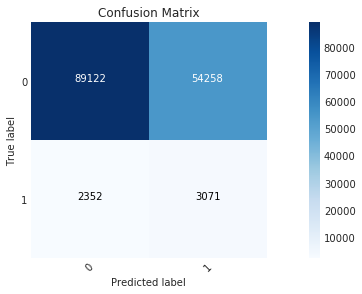

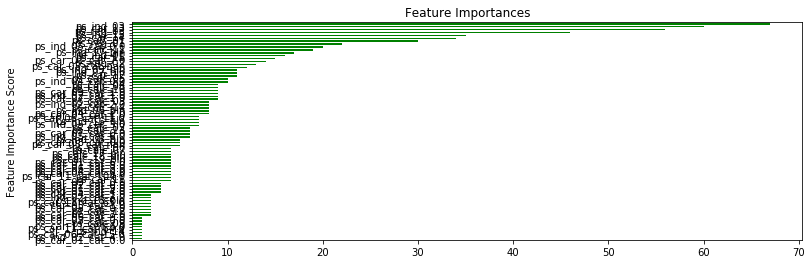

In [38]:
modelfit(xgbc,X_train_sample,y_train_sample,X_test,y_test,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [39]:
params['n_estimators']=114

## 2.2 Trune Params
### 2.2.1 first round

### （1） max_depth

In [40]:
searchParam={'max_depth':[1,2,3,4,5,6]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
max_depth : 4
Best score: 0.264471320307
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.248129          0.259483        0.010148         0.002828
1         0.259544          0.289743        0.011632         0.003270
2         0.263158          0.321201        0.012762         0.003885
3         0.264471          0.364454        0.013655         0.004299
4         0.262255          0.421117        0.014640         0.002608
5         0.259654          0.492926        0.013900         0.004490


### （2）min_child_weight

In [41]:
searchParam={'min_child_weight':np.arange(0.9,0.95,0.005)}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
min_child_weight : 0.9
Best score: 0.264471320307
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.264471          0.364454        0.013655         0.004299
1         0.264471          0.364454        0.013655         0.004299
2         0.264471          0.364454        0.013655         0.004299
3         0.264471          0.364454        0.013655         0.004299
4         0.264471          0.364454        0.013655         0.004299
5         0.264471          0.364454        0.013655         0.004299
6         0.264471          0.364454        0.013655         0.004299
7         0.264471          0.364454        0.013655         0.004299
8         0.264471          0.364454        0.013655         0.004299
9         0.264471          0.364454        0.013655         0.004299


In [42]:
searchParam={'min_child_weight':[0.1,0.3,0.5,0.7,0.9]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
min_child_weight : 0.1
Best score: 0.264471320307
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.264471          0.364454        0.013655         0.004298
1         0.264471          0.364454        0.013655         0.004298
2         0.264471          0.364454        0.013655         0.004299
3         0.264471          0.364454        0.013655         0.004299
4         0.264471          0.364454        0.013655         0.004299


In [43]:
searchParam={'min_child_weight':[0,1e-3,0.05,0.1,0.15]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
min_child_weight : 0
Best score: 0.264471320307
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.264471          0.364454        0.013655         0.004298
1         0.264471          0.364454        0.013655         0.004298
2         0.264471          0.364454        0.013655         0.004298
3         0.264471          0.364454        0.013655         0.004298
4         0.264471          0.364454        0.013655         0.004298


### （3）gamma

In [53]:
searchParam={'gamma':[0,1e-3,0.1,1,10]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
gamma : 0.1
Best score: 0.263569203521
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.263491          0.350699        0.014058         0.004463
1         0.263491          0.350699        0.014058         0.004463
2         0.263569          0.350087        0.014382         0.003872
3         0.262887          0.350602        0.014327         0.003424
4         0.257451          0.292535        0.012873         0.004715


In [54]:
searchParam={'gamma':[0.05,0.07,0.09,0.1,0.11,0.13]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
gamma : 0.07
Best score: 0.26365072483
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.263552          0.350651        0.014313         0.004520
1         0.263651          0.350541        0.014258         0.004443
2         0.263569          0.350087        0.014382         0.003872
3         0.263569          0.350087        0.014382         0.003872
4         0.263569          0.350087        0.014382         0.003872
5         0.263569          0.350087        0.014382         0.003872


In [55]:
searchParam={'gamma':[0.06,0.065,0.07,0.075]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
gamma : 0.06
Best score: 0.26365072483
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.263651          0.350541        0.014258         0.004443
1         0.263651          0.350541        0.014258         0.004443
2         0.263651          0.350541        0.014258         0.004443
3         0.263569          0.350087        0.014382         0.003872


### （4）subsample

In [57]:
searchParam={'subsample':[0.3,0.5,0.7,0.8,0.9,1.0]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
subsample : 1.0
Best score: 0.26365072483
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.252529          0.346079        0.013438         0.002797
1         0.260474          0.354051        0.016551         0.002100
2         0.263205          0.355357        0.014425         0.005180
3         0.262978          0.355101        0.013159         0.003462
4         0.262838          0.354528        0.016228         0.004037
5         0.263651          0.350541        0.014258         0.004443


### (5)colsample_bytree

In [59]:
searchParam={'colsample_bytree':[0.2,0.4,0.6,0.8,1.0]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
colsample_bytree : 1.0
Best score: 0.26365072483
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.262701          0.329365        0.013891         0.003610
1         0.260600          0.339848        0.012370         0.003893
2         0.262343          0.343656        0.013759         0.003290
3         0.259757          0.347414        0.013780         0.004502
4         0.263651          0.350541        0.014258         0.004443


### （6）reg_alpha

In [60]:
searchParam={'reg_alpha':[0,1e-3,0.1,0.5,1.0,5,10]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
reg_alpha : 10
Best score: 0.263746787725
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.263651          0.350541        0.014258         0.004443
1         0.263283          0.350552        0.013885         0.004423
2         0.261257          0.350528        0.012694         0.004775
3         0.262341          0.351129        0.013918         0.003749
4         0.262579          0.351803        0.014312         0.004275
5         0.263427          0.343178        0.013570         0.004341
6         0.263747          0.335924        0.013644         0.004131


In [62]:
searchParam={'reg_alpha':[6,8,10,12,14]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
reg_alpha : 14
Best score: 0.26403439138
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.262097          0.341403        0.014398         0.004308
1         0.263741          0.338120        0.014782         0.004537
2         0.263747          0.335924        0.013644         0.004131
3         0.263640          0.332909        0.014414         0.003603
4         0.264034          0.330346        0.014094         0.003798


In [63]:
searchParam={'reg_alpha':[13,14,15,16,17]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
reg_alpha : 14
Best score: 0.26403439138
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.263547          0.330810        0.014502         0.003796
1         0.264034          0.330346        0.014094         0.003798
2         0.263626          0.328837        0.013389         0.004070
3         0.263542          0.327763        0.014271         0.003720
4         0.262686          0.326464        0.013081         0.004384


### （7）reg_lambda

In [64]:
searchParam={'reg_lambda':[0,1e-3,0.1,1.0,5,10]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
reg_lambda : 1.0
Best score: 0.26403439138
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.263414          0.330049        0.014140         0.003925
1         0.263414          0.330049        0.014140         0.003925
2         0.263679          0.330247        0.013833         0.003979
3         0.264034          0.330346        0.014094         0.003798
4         0.263348          0.329441        0.013707         0.004047
5         0.262493          0.328383        0.013624         0.003982


In [65]:
searchParam={'reg_lambda':[0.6,0.8,0.9,1.0,1.1,1.2,1.4]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
reg_lambda : 0.8
Best score: 0.26421027802
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.263980          0.330332        0.013879         0.004538
1         0.264210          0.330318        0.014387         0.003820
2         0.264077          0.330291        0.013958         0.003982
3         0.264034          0.330346        0.014094         0.003798
4         0.263712          0.330397        0.013817         0.003758
5         0.263438          0.330315        0.013689         0.003769
6         0.263780          0.329919        0.013727         0.004187


In [66]:
searchParam={'reg_lambda':[0.7,0.75,0.79,0.8,0.81,0.85]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
reg_lambda : 0.81
Best score: 0.264403279523
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.264231          0.330614        0.014074         0.004207
1         0.264338          0.330311        0.013880         0.003805
2         0.264157          0.330248        0.014367         0.003893
3         0.264210          0.330318        0.014387         0.003820
4         0.264403          0.330289        0.014098         0.003780
5         0.264361          0.330588        0.014540         0.003891


In [67]:
searchParam={'reg_lambda':[0.805,0.81,0.815,0.82,0.83,0.84]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
reg_lambda : 0.84
Best score: 0.264597490116
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.264403          0.330289        0.014098         0.003780
1         0.264403          0.330289        0.014098         0.003780
2         0.264510          0.330172        0.014149         0.003919
3         0.264510          0.330172        0.014150         0.003919
4         0.264597          0.330452        0.014181         0.003693
5         0.264597          0.330451        0.014181         0.003693


In [68]:
searchParam={'reg_lambda':[0.835,0.839,0.84,0.841,0.845]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
reg_lambda : 0.841
Best score: 0.264597716753
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.264598          0.330452        0.014181         0.003693
1         0.264598          0.330451        0.014181         0.003693
2         0.264597          0.330451        0.014181         0.003693
3         0.264598          0.330451        0.014181         0.003693
4         0.264361          0.330589        0.014539         0.003891


### 2.2.2 second round

### （1）max_depth

In [69]:
searchParam={'max_depth':[1,2,3,4,5,6]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
max_depth : 3
Best score: 0.264597716753
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.249055          0.260399        0.010093         0.002908
1         0.261822          0.293897        0.011114         0.003812
2         0.264598          0.330451        0.014181         0.003693
3         0.264255          0.382553        0.014487         0.002388
4         0.260238          0.455662        0.014099         0.004243
5         0.253506          0.545521        0.013881         0.002039


### （2）min_child_weight

In [70]:
searchParam={'min_child_weight':np.arange(0.9,0.95,0.005)}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
min_child_weight : 0.9
Best score: 0.264597716753
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.264598          0.330451        0.014181         0.003693
1         0.264598          0.330451        0.014181         0.003693
2         0.264598          0.330451        0.014181         0.003693
3         0.264598          0.330451        0.014181         0.003693
4         0.264598          0.330451        0.014181         0.003693
5         0.264598          0.330451        0.014181         0.003693
6         0.264598          0.330451        0.014181         0.003693
7         0.264598          0.330451        0.014181         0.003693
8         0.264598          0.330451        0.014181         0.003693
9         0.264598          0.330451        0.014181         0.003693


### （3）gamma

In [71]:
searchParam={'gamma':[0.06,0.065,0.07,0.075]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
gamma : 0.065
Best score: 0.264599566956
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.264598          0.330451        0.014181         0.003693
1         0.264600          0.330447        0.014180         0.003693
2         0.264466          0.330553        0.014351         0.003917
3         0.264469          0.330550        0.014352         0.003919


In [72]:
searchParam={'gamma':[0.063,0.064,0.065,0.066,0.067]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
gamma : 0.067
Best score: 0.264599982501
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.264598          0.330449        0.014181         0.003695
1         0.264598          0.330449        0.014181         0.003695
2         0.264600          0.330447        0.014180         0.003693
3         0.264600          0.330447        0.014180         0.003693
4         0.264600          0.330445        0.014180         0.003695


In [73]:
searchParam={'gamma':[0.0665,0.067,0.0675,0.068,0.0685,0.069]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
gamma : 0.067
Best score: 0.264599982501
   mean_test_score  mean_train_score  std_test_score  std_train_score
0           0.2646          0.330447         0.01418         0.003693
1           0.2646          0.330445         0.01418         0.003695
2           0.2646          0.330445         0.01418         0.003695
3           0.2646          0.330445         0.01418         0.003695
4           0.2646          0.330445         0.01418         0.003695
5           0.2646          0.330445         0.01418         0.003695


### （4）reg_alpha

In [74]:
searchParam={'reg_alpha':[13,14,15,16,17]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
reg_alpha : 14
Best score: 0.264599982501
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.263337          0.331621        0.014637         0.003545
1         0.264600          0.330445        0.014180         0.003695
2         0.263463          0.329101        0.013271         0.004078
3         0.263849          0.327560        0.013723         0.003652
4         0.263005          0.326016        0.012057         0.004607


In [76]:
searchParam={'reg_alpha':[13.5,13.7,13.9,14,14.1,14.3,14.5]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
reg_alpha : 14
Best score: 0.264599982501
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.263378          0.330893        0.013666         0.004171
1         0.263708          0.330834        0.013810         0.004345
2         0.264066          0.330675        0.014082         0.004225
3         0.264600          0.330445        0.014180         0.003695
4         0.263102          0.330167        0.014045         0.003895
5         0.263587          0.329996        0.013705         0.003861
6         0.264460          0.330175        0.014387         0.003754


### （5）reg_lambda

In [77]:
searchParam={'reg_lambda':[0.835,0.839,0.84,0.841,0.845]}
turnParams(xgbc,X_train_sample,y_train_sample,searchParam,params,scoring=gini_normalized_ordinary_model,cv=5)

Best params:
reg_lambda : 0.841
Best score: 0.264599982501
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.264600          0.330446        0.014180         0.003695
1         0.264600          0.330445        0.014180         0.003695
2         0.264600          0.330445        0.014180         0.003695
3         0.264600          0.330445        0.014180         0.003695
4         0.264342          0.330508        0.014571         0.003784


### 2.2.3 lower learning_rate

### （1）learning_rate=0.08

In [79]:
params['learning_rate']=0.08

In [80]:
xgbc_tp=XGBClassifier(**params)

[0]	train-NormGini:-0.185925+0.00190164	test-NormGini:-0.174591+0.00319816
[20]	train-NormGini:-0.264333+0.00170603	test-NormGini:-0.23865+0.00735136
[40]	train-NormGini:-0.281281+0.00149655	test-NormGini:-0.250565+0.00720504
[60]	train-NormGini:-0.291736+0.00169932	test-NormGini:-0.257555+0.00596935
[80]	train-NormGini:-0.300253+0.00134172	test-NormGini:-0.260901+0.00628352
[100]	train-NormGini:-0.307898+0.00105506	test-NormGini:-0.262439+0.00660831
[120]	train-NormGini:-0.314848+0.00123144	test-NormGini:-0.264187+0.00609721
[140]	train-NormGini:-0.321185+0.00160824	test-NormGini:-0.264474+0.00623127
[160]	train-NormGini:-0.327277+0.00128928	test-NormGini:-0.265257+0.00643407
[180]	train-NormGini:-0.332857+0.00150471	test-NormGini:-0.265494+0.00666244
Best Iteration: 165
Model report on trian:
Train Accuracy:0.6147
Train AUC:0.6604
Train Normalized GINI：0.320728
Model report on test:
Test Accuracy:0.6202
Test AUC:0.6325
Test Normalized GINI：0.264902
Test classifiction report:
        

ps_ind_14          1
ps_calc_20_bin     1
ps_ind_18_bin      2
ps_car_02_cat      4
ps_calc_06         4
ps_calc_12         6
ps_ind_08_bin      6
ps_calc_19_bin     6
ps_calc_18_bin     7
ps_calc_09         8
ps_calc_17_bin     9
ps_car_08_cat     10
ps_ind_07_bin     10
ps_ind_06_bin     11
ps_ind_16_bin     11
ps_calc_02        11
ps_calc_14        11
ps_car_04_cat     12
ps_calc_13        13
ps_car_12         13
ps_car_09_cat     13
ps_calc_07        15
ps_ind_04_cat     15
ps_calc_10        15
ps_car_05_cat     16
ps_car_11_cat     17
ps_car_11         17
ps_calc_08        17
ps_reg_02         18
ps_ind_09_bin     20
ps_ind_17_bin     21
ps_calc_11        21
ps_calc_03        22
ps_car_07_cat     23
ps_car_03_cat     24
ps_calc_05        25
ps_ind_01         25
ps_calc_04        26
ps_ind_02_cat     27
ps_car_15         27
ps_car_06_cat     31
ps_calc_01        35
ps_car_01_cat     40
ps_ind_05_cat     43
ps_car_14         47
ps_reg_01         51
ps_ind_15         69
ps_reg_03    

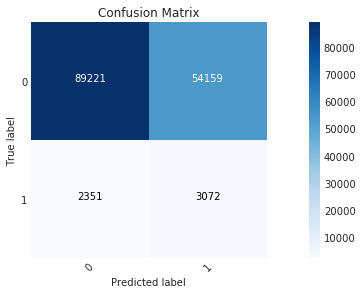

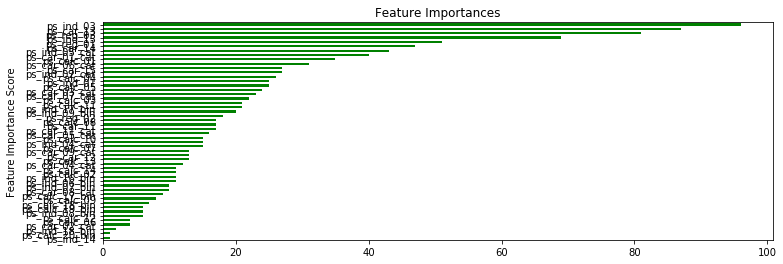

In [81]:
modelfit(xgbc_tp,X_train_sample,y_train_sample,X_test,y_test,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

### （2）larning_rate=0.07

In [85]:
params['learning_rate']=0.07

[0]	train-NormGini:-0.185925+0.00190164	test-NormGini:-0.174591+0.00319816
[20]	train-NormGini:-0.261206+0.00219232	test-NormGini:-0.235872+0.00800003
[40]	train-NormGini:-0.277224+0.00134539	test-NormGini:-0.247278+0.00806554
[60]	train-NormGini:-0.28867+0.00153161	test-NormGini:-0.25489+0.00814579
[80]	train-NormGini:-0.296289+0.00152154	test-NormGini:-0.258827+0.00774218
[100]	train-NormGini:-0.303425+0.00132173	test-NormGini:-0.261168+0.00761672
[120]	train-NormGini:-0.309694+0.00162827	test-NormGini:-0.262649+0.00719647
[140]	train-NormGini:-0.31568+0.00175951	test-NormGini:-0.263694+0.00709449
[160]	train-NormGini:-0.321146+0.00184516	test-NormGini:-0.264279+0.00724857
[180]	train-NormGini:-0.32619+0.00200063	test-NormGini:-0.264422+0.00716618
[200]	train-NormGini:-0.331478+0.00194244	test-NormGini:-0.265362+0.00710674
[220]	train-NormGini:-0.336356+0.00175555	test-NormGini:-0.265522+0.00728505
[240]	train-NormGini:-0.340754+0.00159364	test-NormGini:-0.265676+0.00763888
[260]	tra

ps_ind_18_bin       2
ps_ind_08_bin       6
ps_calc_06          8
ps_car_02_cat       9
ps_calc_18_bin     10
ps_ind_16_bin      11
ps_ind_07_bin      12
ps_calc_09         12
ps_calc_19_bin     12
ps_ind_06_bin      14
ps_calc_12         14
ps_car_08_cat      15
ps_calc_17_bin     15
ps_car_04_cat      17
ps_car_05_cat      19
ps_calc_14         19
ps_calc_13         19
ps_calc_10         21
ps_calc_07         21
ps_ind_04_cat      21
ps_calc_02         21
ps_car_11          21
ps_car_12          23
ps_calc_08         26
ps_ind_17_bin      26
ps_ind_09_bin      27
ps_car_11_cat      27
ps_car_07_cat      28
ps_ind_02_cat      29
ps_reg_02          30
ps_calc_05         30
ps_calc_03         30
ps_car_09_cat      30
ps_car_03_cat      31
ps_calc_11         35
ps_ind_01          36
ps_calc_04         42
ps_car_06_cat      45
ps_car_15          46
ps_ind_05_cat      54
ps_calc_01         57
ps_car_01_cat      57
ps_reg_01          75
ps_car_14          89
ps_ind_15          90
ps_reg_03 

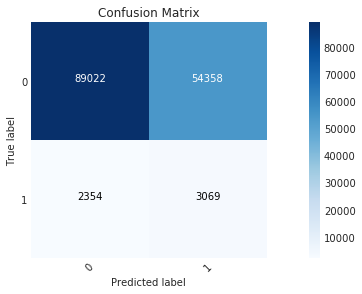

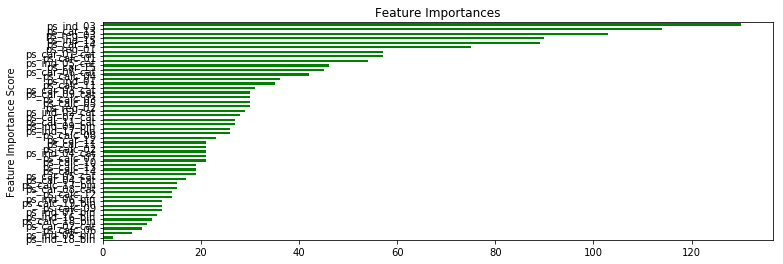

In [86]:
xgbc_tp=XGBClassifier(**params)
modelfit(xgbc_tp,X_train_sample,y_train_sample,X_test,y_test,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

### （3）learning_rate=0.071

[0]	train-NormGini:-0.185925+0.00190164	test-NormGini:-0.174591+0.00319816
[20]	train-NormGini:-0.261616+0.00207104	test-NormGini:-0.236552+0.0079211
[40]	train-NormGini:-0.277388+0.00130566	test-NormGini:-0.24749+0.00835797
[60]	train-NormGini:-0.288642+0.00135136	test-NormGini:-0.255045+0.00814626
[80]	train-NormGini:-0.297388+0.00151079	test-NormGini:-0.259961+0.00741197
[100]	train-NormGini:-0.303929+0.00146385	test-NormGini:-0.261984+0.00728855
[120]	train-NormGini:-0.310415+0.00184472	test-NormGini:-0.263239+0.0074781
[140]	train-NormGini:-0.316529+0.00189547	test-NormGini:-0.263779+0.00741553
[160]	train-NormGini:-0.321883+0.00205115	test-NormGini:-0.264689+0.00685027
[180]	train-NormGini:-0.327305+0.00223098	test-NormGini:-0.264517+0.00674312
[200]	train-NormGini:-0.33259+0.00205314	test-NormGini:-0.264943+0.00729402
[220]	train-NormGini:-0.337325+0.00172584	test-NormGini:-0.265111+0.00745352
[240]	train-NormGini:-0.342176+0.00167117	test-NormGini:-0.265392+0.00770306
[260]	tra

ps_ind_14           1
ps_ind_18_bin       4
ps_calc_06          7
ps_car_02_cat       7
ps_ind_08_bin      11
ps_calc_19_bin     11
ps_calc_18_bin     11
ps_calc_12         12
ps_ind_07_bin      13
ps_ind_06_bin      13
ps_ind_16_bin      13
ps_car_04_cat      13
ps_calc_09         13
ps_calc_17_bin     16
ps_car_08_cat      17
ps_calc_14         18
ps_calc_02         18
ps_car_05_cat      19
ps_calc_13         19
ps_ind_04_cat      20
ps_calc_07         20
ps_car_11          21
ps_ind_09_bin      24
ps_calc_10         24
ps_calc_08         25
ps_ind_17_bin      25
ps_car_12          26
ps_car_07_cat      27
ps_car_09_cat      27
ps_car_03_cat      29
ps_car_11_cat      30
ps_reg_02          30
ps_calc_11         34
ps_ind_02_cat      34
ps_calc_03         34
ps_calc_05         38
ps_car_15          42
ps_calc_04         43
ps_ind_01          48
ps_car_06_cat      48
ps_car_01_cat      51
ps_ind_05_cat      53
ps_calc_01         55
ps_reg_01          76
ps_car_14          77
ps_ind_15 

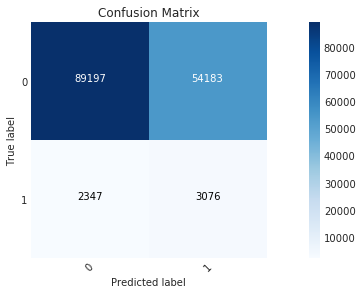

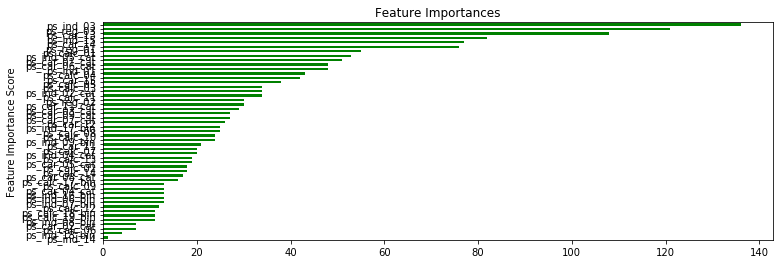

In [89]:
params['learning_rate']=0.071
xgbc_tp=XGBClassifier(**params)
modelfit(xgbc_tp,X_train_sample,y_train_sample,X_test,y_test,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [92]:
params['n_estimators']=237
params

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1.0,
 'gamma': 0.067,
 'learning_rate': 0.071,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 0.90000000000000002,
 'missing': None,
 'n_estimators': 237,
 'nthread': -1,
 'objective': 'binary:logistic',
 'reg_alpha': 14,
 'reg_lambda': 0.841,
 'scale_pos_weight': 1.0,
 'seed': 9,
 'silent': True,
 'subsample': 1.0}

## 3 Predict

In [93]:
xgb_opt=XGBClassifier(**params)

In [94]:
xgb_opt.fit(X_train_sample,y_train_sample)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1.0,
       gamma=0.067, learning_rate=0.071, max_delta_step=0, max_depth=3,
       min_child_weight=0.90000000000000002, missing=None,
       n_estimators=237, nthread=-1, objective='binary:logistic',
       reg_alpha=14, reg_lambda=0.841, scale_pos_weight=1.0, seed=9,
       silent=True, subsample=1.0)

In [95]:
pred_prob=xgb_opt.predict_proba(X_predict)[:,1]

In [96]:
predict_result=pd.DataFrame({'id':test_df['id'].astype(int),'target':pd.Series(pred_prob,index=test_df['id'].index)})

In [97]:
predict_result.head()

,id,target
0,0,0.383137
1,1,0.410064
2,2,0.436474
3,3,0.313332
4,4,0.499062


In [98]:
predict_result.to_csv('/home/yw/study/Competition/Safe_Driver_Prediction_20171014/20171017_05xgb_under_sample.csv',index=False)